# necessary imports

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

In [ ]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")

Using device: /GPU:0


# helper functions :

Define the file paths for the images and ground truth labels.

In [ ]:
# Define paths
image_folder = "/content/drive/MyDrive/Data Science/S3/CV/remote_sensing/images_gts/images_inter"
ground_truth_folder = "/content/drive/MyDrive/Data Science/S3/CV/remote_sensing/images_gts/gt_edge_inter"

Load the images and ground truth edge maps from drive.

In [ ]:
# Step 2: Load dataset
def load_dataset(image_folder, ground_truth_folder):
    images = []
    ground_truths = []
    for filename in sorted(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    for filename in sorted(os.listdir(ground_truth_folder)):
        gt = cv2.imread(os.path.join(ground_truth_folder, filename), cv2.IMREAD_GRAYSCALE)
        if gt is not None:
            ground_truths.append(gt)
    return np.array(images), np.array(ground_truths)

Define the U-Net architecture with downsampling (encoder) and upsampling (decoder) layers.

In [ ]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling path
    u1 = UpSampling2D((2, 2))(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# preprocessing

load the dataset using th load_dataset function

In [ ]:
# Load dataset
images, ground_truths = load_dataset(image_folder, ground_truth_folder)

normalize the images for more normal distribution of the pixels

In [ ]:
# Normalize the images and ground truths
images = images / 255.0
ground_truths = ground_truths / 255.0

resizing the images for more effcient training

In [ ]:
# Resize images and ground truths to a consistent size
IMG_HEIGHT, IMG_WIDTH = 256, 256
images_resized = np.array([cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) for img in images])
ground_truths_resized = np.array([cv2.resize(gt, (IMG_WIDTH, IMG_HEIGHT)) for gt in ground_truths])

In [ ]:
# Expand dimensions
images_resized = np.expand_dims(images_resized, axis=-1)
ground_truths_resized = np.expand_dims(ground_truths_resized, axis=-1)

# training

split the data to training data and test data

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images_resized, ground_truths_resized, test_size=0.2, random_state=42)

training the model on the preprocessed data

In [ ]:
# Initialize the model on the chosen device
with tf.device(device):
    model = unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=8, epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 845ms/step - accuracy: 0.9619 - loss: 0.5966 - val_accuracy: 0.9585 - val_loss: 0.1742
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9616 - loss: 0.1873 - val_accuracy: 0.9585 - val_loss: 0.1505
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.9641 - loss: 0.1477 - val_accuracy: 0.9585 - val_loss: 0.1412
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.9624 - loss: 0.1467 - val_accuracy: 0.9585 - val_loss: 0.1335
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.9642 - loss: 0.1263 - val_accuracy: 0.9585 - val_loss: 0.1233
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.9631 - loss: 0.1152 - val_accuracy: 0.9585 - val_loss: 0.1145
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.9644 - loss: 0.1037 - val_accuracy: 0.9585 - val_loss: 0.1116
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.9630 - loss: 0.1029 - val_accuracy: 0

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step - accuracy: 0.9585 - loss: 0.1090
Test Loss: 0.1090
Test Accuracy: 0.9585


plotting th learning curve, which shows the loss during training

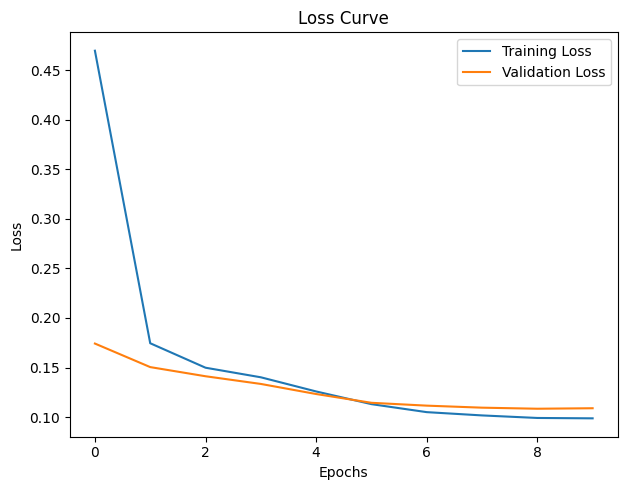

In [ ]:
import matplotlib.pyplot as plt

# Extract data from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# testing the model

input image of the same size

In [ ]:
# Select an image from the test set
index = 0
jndex = 9  # Change the index to try different images
test_image = X_test[index]
ground_truth = y_test[index]
test_image_j = X_test[jndex]
ground_truth_j = y_test[jndex]

predicting the mask for the input images, which contains the detected edges using the trained model

In [ ]:
# Predict the mask for the selected test image
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]
predicted_mask_j = model.predict(np.expand_dims(test_image_j, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
# Apply threshold
predicted_edge = (predicted_mask > 0.5).astype(np.uint8)
predicted_edge_j = (predicted_mask_j > 0.5).astype(np.uint8)

the edge mapped map using the trained model

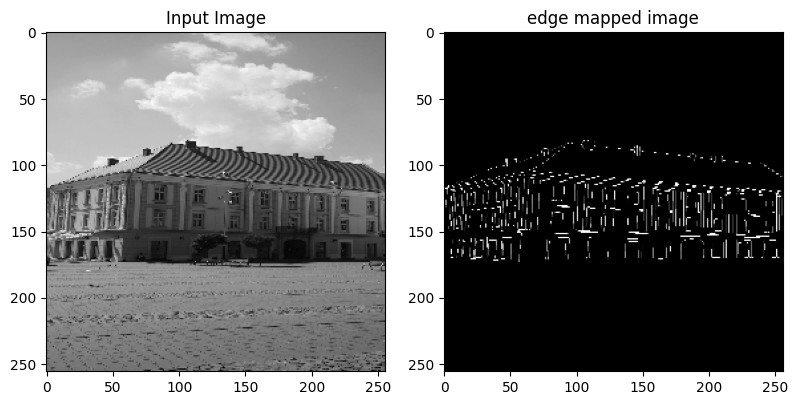

In [ ]:
# Display results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_image.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("edge mapped image")
plt.imshow(predicted_edge.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

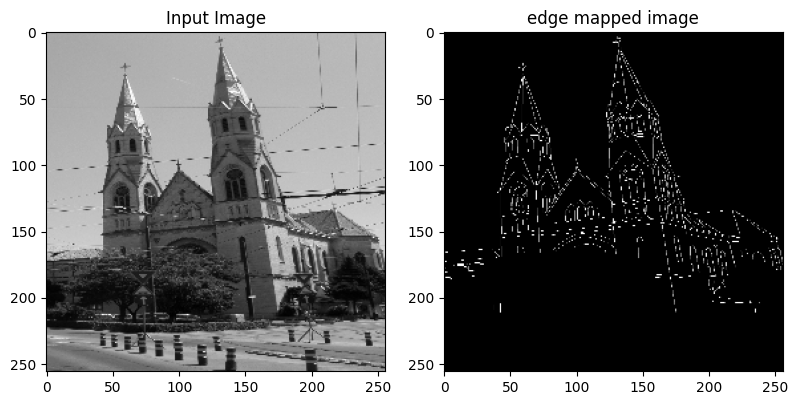

In [ ]:
# Display results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_image_j.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("edge mapped image")
plt.imshow(predicted_edge_j.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()